# Coursework 3: Bilinear Inverse Problems and Low-Rank Matrix Recovery

[] By tick the checkbox, we hereby declare that this coursework report is our own and autonomous work. We have acknowledged all material and sources used in its preparation, including books, articles, reports, lecture notes, internet software packages, and any other kind of document, electronic or personal communication. This work has not been submitted for any other assessment.

## 3.1 Test Data Generation (10%)

We consider the low-rank matrix completion problem given by 
$$
    \bm{y} = \mathcal{P}_{\Omega}(\bm{X}) 
$$
where $\bm{X} \in \mathbb{R}^{m \times n}$ is a low rank matrix of rank $r$. 

Data generation: Write $\bm{X} = \bm{U} \bm{G} \bm{V}^{\mathsf{T}}$, where $\bm{U} \in \mathbb{R}^{m \times r}$, $\bm{G} \in \mathbb{R}^{r \times r}$, and $\bm{V} \in \mathbb{R}^{n \times r}$ are matrices with i.i.d. $\mathcal{N}(0,1)$ Gaussian entries. (Note that by $\bm{X} = \bm{U} \bm{G} \bm{V}^{\mathsf{T}}$ we are not talking about SVD.)


Design and implement a function `LRMC_data_gen` to generate test data. Provide necessary documentation.

In [15]:
using Random
using LinearAlgebra
using StatsBase
using Distributions
using Plots

# Helper functions

function nuclear_norm(X)
    _, S, _ = svd(X)
    return sum(S)
end

function current_cost(X, Y, Ω, λ)
    return 0.5 * norm(X[Ω] - Y[Ω])^2 + λ * nuclear_norm(X)
end

function Singular_value_soft_threshold(X, λ)
    U, S, V = svd(X)
    threshold = max.(S .- λ, 0.0)
    return U * Diagonal(threshold) * V'
end

# Low Rank Matrix Completion Iterative Shrinkage Thresholding Algorithm.

function LRMCRec_ISTA(Y, Ω, λ, iterations)
    X = copy(Y)

    cost_list = zeros(iterations + 1)
    cost_list[1] = current_cost(X, Y, Ω, λ)

    for i=1:iterations
        X[Ω] = Y[Ω]
        X = Singular_value_soft_threshold(X, λ)

        cost_list[i+1] = current_cost(X, Y, Ω, λ)
    end

    return X, cost_list
end

LRMCRec_ISTA (generic function with 1 method)

## 3.2 Matrix Completion Techniques

In the following, the suggested simulation setup is that $m = 32$, $n=48$, $r$ varies in $2:2:8$, and $|\Omega|/mn$ varies in $\{1/8,~ 1/6,~ 1/4,~ 1/2\}$. 

### 3.2.1 Alternating Minimization (20%)

Design, implement, and run tests for the alternating minimization method for low-rank matrix completion. Use the function name `LRMCRec_AM`. Provide necessary documentation.

### 3.2.2 Iterative Hard Thresholding (IHT) (20%)

Design, implement, and run simple tests for the IHT algorithm for low-rank matrix completion. Use the function name `LRMCRec_IHT`. Provide necessary documentation. 

In [17]:
function r_rank_approx(M, r::Int)
    # Gives a r-rank approximation to the input matrix M 
        U, Σ, V = svd(M)
        N = length(Σ)
    
        for i = r+1:N
            Σ[i] = 0
        end
    
        return U * Diagonal(Σ) * V'
    end
    
    function LRMCRec_IHT(Y, Ω, r::Int, τ::Float64, iters::Int)
    # Iterative Hard Thresholding Function for low-rank-approximation of X
        m, n = size(Y)
        X = copy(Y)
        
        temp = zeros(m,n)   
        cost_list = []
    
        for i = 1:iters
            # Iteration algorithm to reduce objective error 
            temp[Ω] = Y[Ω] - X[Ω]
            X = r_rank_approx(X + τ*(temp), r)
            
            #Calculate current cost
            cost = norm(Y[Ω] - X[Ω], 2)^2
            append!(cost_list, cost)
    
        end 
        return X, cost_list
    end

LRMCRec_IHT (generic function with 2 methods)

In [18]:
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

log = []

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="IHT for r=$(rank)", ylabel="final error", xlabel="τ")

    for sample_idx = 1:length(samples)

        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)
        info_τ = []
        info_error = []

        for τ = 0.01:0.1:1.0
            iters = 100
            X_predict, _ = LRMCRec_IHT(Y, Ω, rank, τ, iters)
            error = norm(X_predict - X) / norm(X)

            push!(info_τ, τ)
            push!(info_error, error)

            push!(log, (rank, sample_ratio, τ, error))
        end

        plot!(plotter, info_τ, info_error, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=2080)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

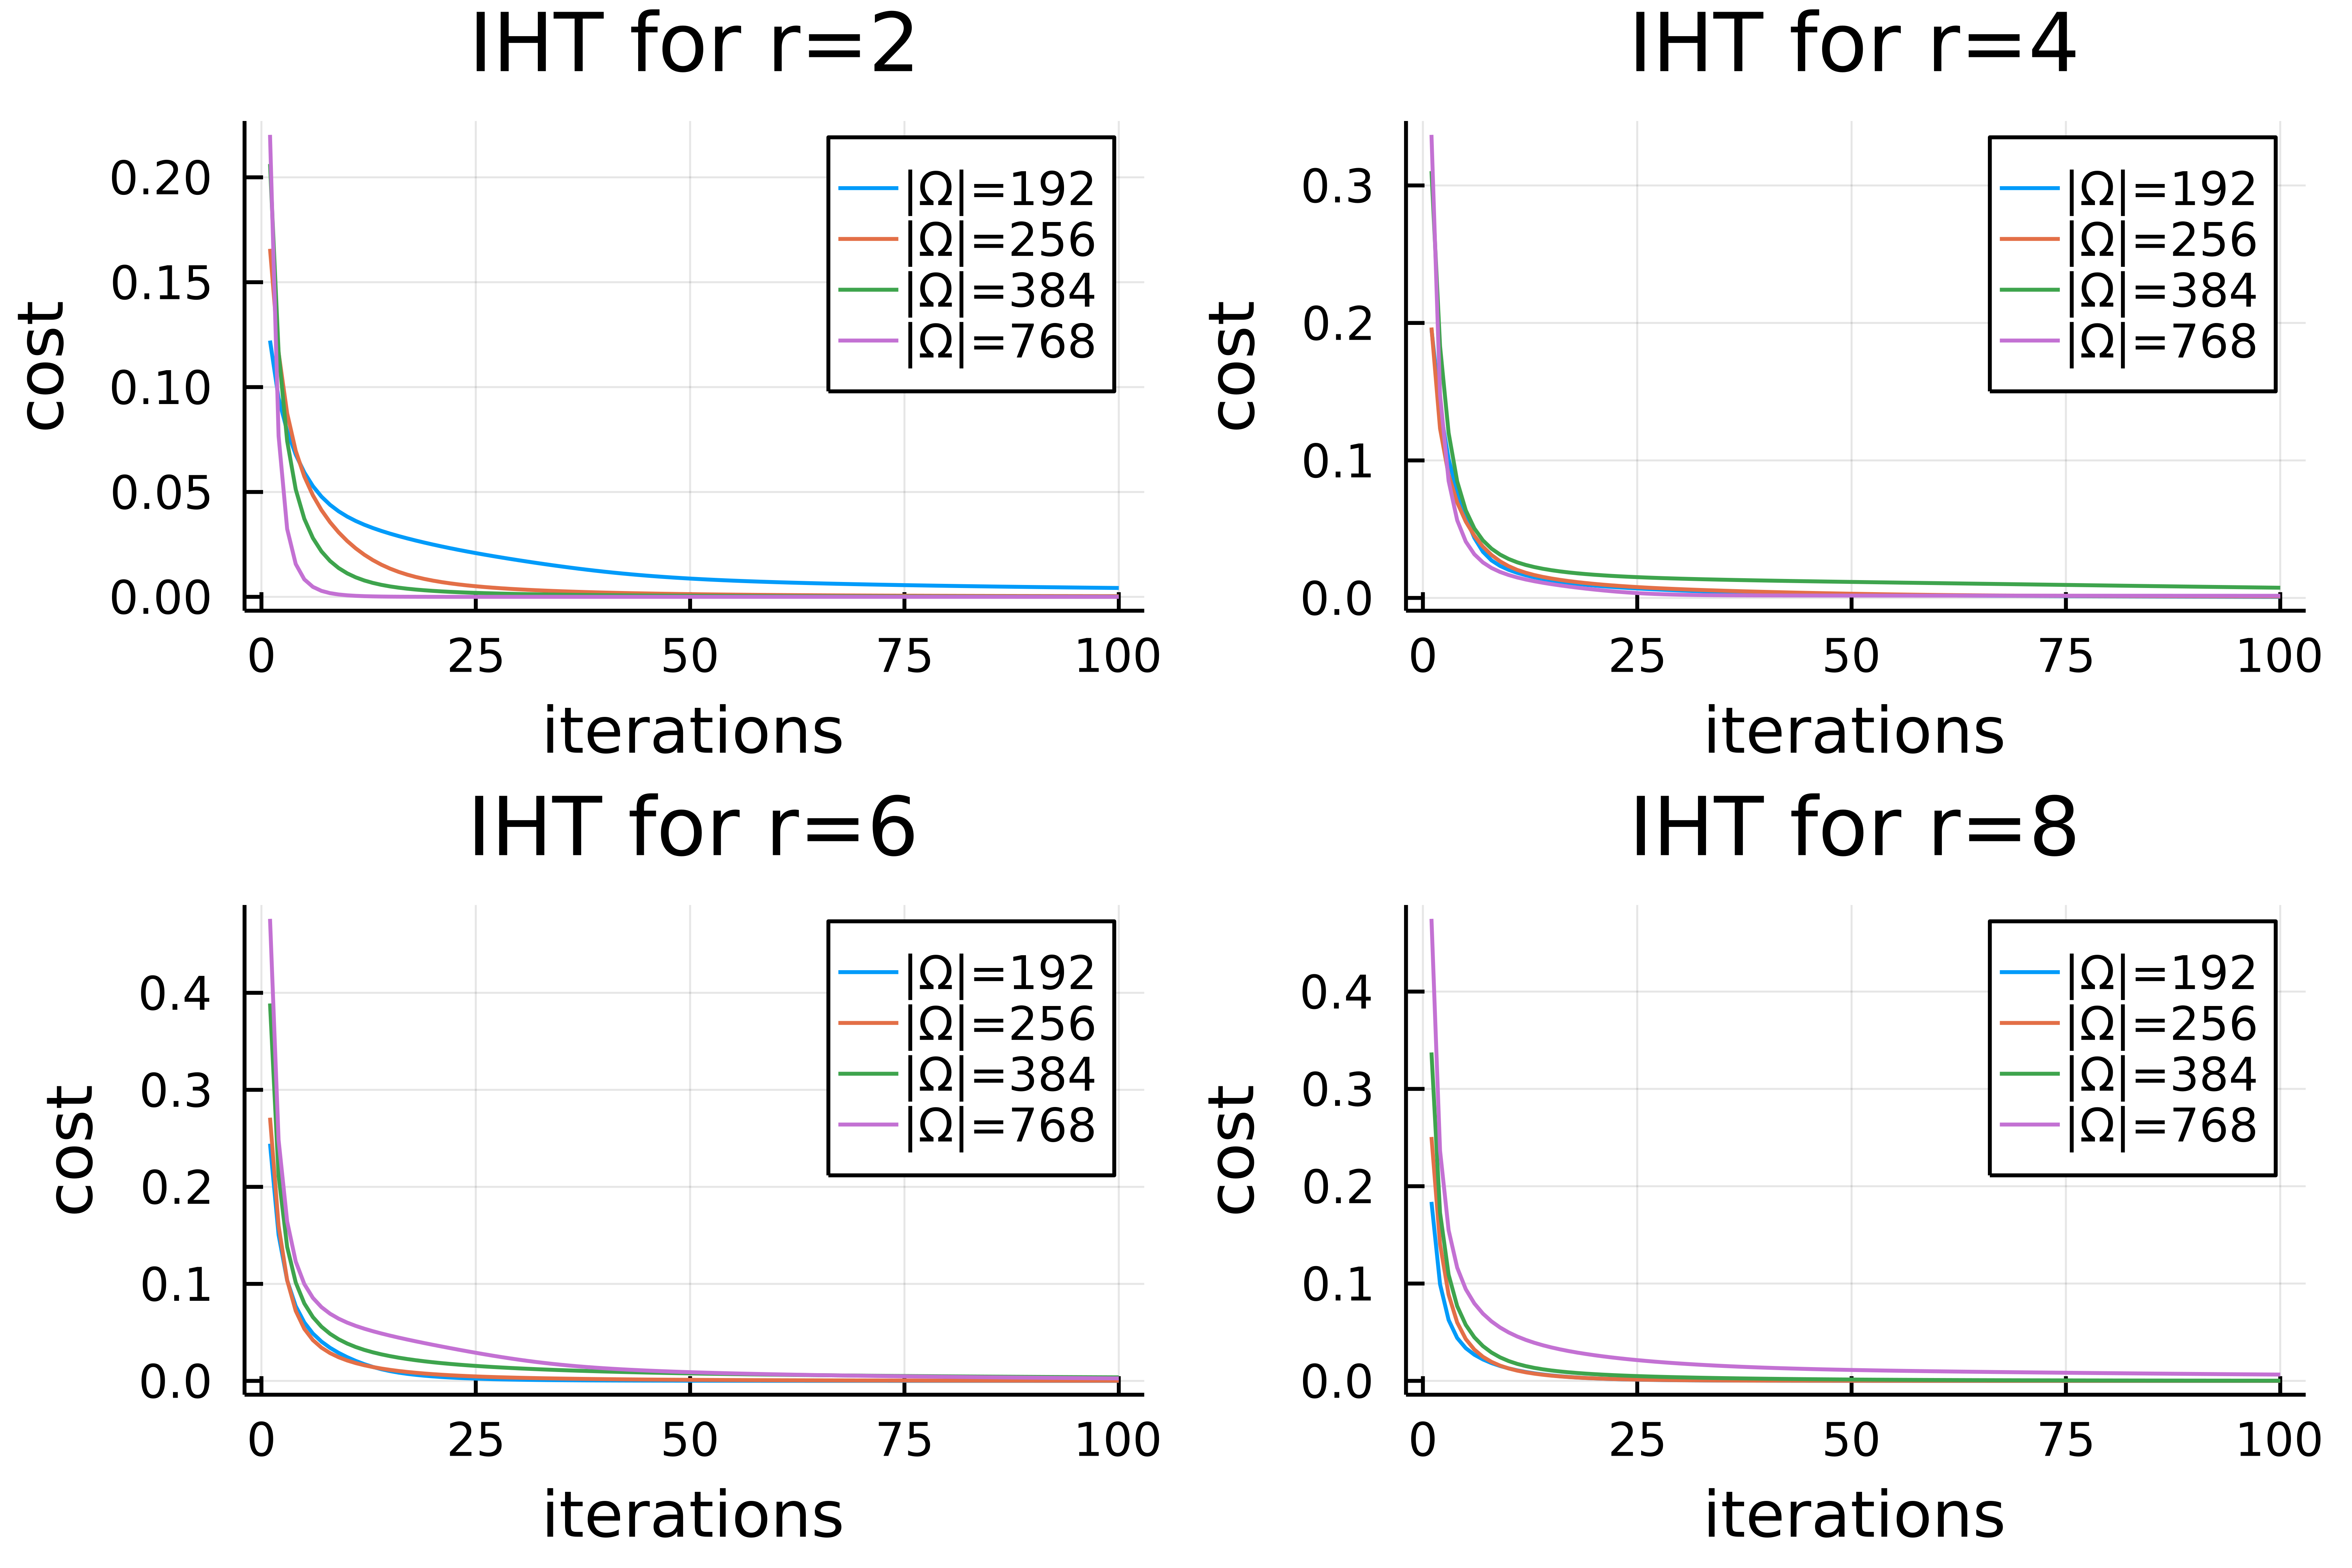

In [19]:
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="IHT for r=$(rank)", ylabel="cost", xlabel="iterations")

    for sample_idx = 1:length(samples)
        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)

        τ = 1.0
        iters = 100
        X_predict, cost_list = LRMCRec_IHT(Y, Ω, rank, τ, iters)
        plot!(plotter, cost_list, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=1040)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

The cost function converges to a sufficiently small value in all cases regardless of the rank of $X$ and the number of revealed entries |Ω|

### 3.2.3 Iterative Shrinkage-Thresholding Algorithm (ISTA) (25%)

Design, implement, and run simple tests for ISTA (to solve the Lasso formulation) for low-rank matrix completion. Use the function name `LRMCRec_ISTA`. Provide necessary documentation. Use simulations to discuss the choice of parameters.

### 3.2.4 Lasso-ADMM (25%)

Design, implement, and run simple tests for an ADMM algorithm (to solve the Lasso formulation) for low-rank matrix completion. Use the function name `LRMCRec_ADMM`. Provide necessary documentation. Compare ADMM and ISTA in terms of convergence.

## Highlight

Please list a couple of highlights of your coursework that may impress your markers.